# PROJECT 01 - TORONTO CRIME ANALYSIS

In [4]:
# Dependencies and setup 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import gmaps
import os
import json
from pprint import pprint
import calendar
import scipy.stats as st
from sklearn import datasets
pd.set_option('mode.chained_assignment', None)

# Import API key
from config import g_key

ModuleNotFoundError: No module named 'config'

In [ ]:
# Read csv files and store in dataframes
file1="Data/Assault_2014_to_2019.csv"
file2="Data/Auto_Theft_2014_to_2019.csv"
file3="Data/Bicycle_Thefts.csv"
file4="Data/Break_and_Enter_2014_to_2019.csv"
file5="Data/Homicide.csv"
file6="Data/MCI_2014_to_2019.csv"
file7="Data/Robbery_2014_to_2019.csv"
file8="Data/Theft_Over_2014_to_2019.csv"
assault=pd.read_csv(file1)
auto_theft=pd.read_csv(file2)
bicycle_theft=pd.read_csv(file3)
break_enter=pd.read_csv(file4)
homicide=pd.read_csv(file5)
mci=pd.read_csv(file6)
robbery=pd.read_csv(file7)
theft_over=pd.read_csv(file8)

In [ ]:
assault.head(1)

In [ ]:
auto_theft.head(1)

In [ ]:
bicycle_theft.head(1)

In [ ]:
break_enter.head(1)

In [ ]:
homicide.head(1)

In [ ]:
mci.head(1)

In [ ]:
robbery.head(1)

In [10]:
theft_over.head(1)

,Index_,event_unique_id,occurrencedate,reporteddate,premisetype,ucr_code,ucr_ext,offence,reportedyear,reportedmonth,...,occurrencedayofyear,occurrencedayofweek,occurrencehour,MCI,Division,Hood_ID,Neighbourhood,Long,Lat,ObjectId
0,20087,GO-20141515313,1392141600000,1392228480000,Commercial,2132,200,Theft From Motor Vehicle Over,2014,February,...,42.0,Tuesday,18,Theft Over,D54,59,Danforth East York (59),-79.319916,43.695885,1


In [11]:
# Check number of crimes in each dataframe
print(len(assault["reportedyear"]))
print(len(auto_theft["reportedyear"]))
print(len(bicycle_theft["Occurrence_Year"]))
print(len(break_enter["reportedyear"]))
print(len(homicide["Occurrence_year"]))
print(len(mci["premisetype"]))
print(len(robbery["reportedyear"]))
print(len(theft_over["reportedyear"]))

111423
23380
21584
43302
1093
206435
21543
6787


####  Observations
1. The MCI dataset lists five different kinds of crimes: assault, auto theft, break and enter, robbery and theft over. However, it does not contain bicycle_theft and homicide data. To get all seven types of crimes, we need to add data from bicycle_theft and homicide files.  In addition, the format of bicycle_theft and homicide data are different to MCI data, for e.g. they are missing some columns like “occurrence month” and the date is in a different format. In order to get the final dataset, we will need to rename the columns of bicycle_theft and homicide to make them consistent with the MCI file.
<br>

2. There are two types of dates in the data sets, reported date and occurrence date. The reported dates are sometimes delayed with respect to the occurrence so we will be analyzing data based on occurrence dates between 2014 and 2019 and not the reported date. 


In [17]:
# Reorganize the dataframe to keep the information we need, and create dataframes for each year from 2014 to 2019

new_mci=mci[["event_unique_id","premisetype","ucr_code","ucr_ext","offence","reportedyear","reportedmonth","reportedday",
             "reporteddayofyear","reporteddayofweek","reportedhour","occurrenceyear","occurrencemonth","occurrenceday",
             "occurrencedayofyear","occurrencedayofweek","occurrencehour","MCI","Division","Hood_ID","Neighbourhood","Long",
             "Lat"]]

new_bicycle_theft=bicycle_theft[["event_unique_id","Premise_Type","Primary_Offence","Occurrence_Year","Occurrence_Month",
                                 "Occurrence_Day","Occurrence_Time","Division","Hood_ID","Neighbourhood","Long","Lat"]]

new_homicide=homicide[["Event_Unique_ID","Occurrence_year","Homicide_Type","Division","Hood_ID",
                       "Neighbourhood","Long","Lat"]]

new_bicycle_theft["MCI"]="bicycle theft"

new_homicide["MCI"]="homicide"

In [18]:
# Rename columns of the dataframes to match
new_bicycle_theft.rename(columns={"Premise_Type":"premisetype","Primary_Offence":"offence","Occurrence_Year":"occurrenceyear",
                                  "Occurrence_Month":"occurrencemonth","Occurrence_Day":"occurrenceday",
                                  "Occurrence_Time":"occurrencehour"},inplace=True)

new_homicide.rename(columns={"Event_Unique_ID":"event_unique_id","Occurrence_year":"occurrenceyear","Homicide_Type":"offence"}
                    ,inplace=True)

new_bicycle_theft.head()

,event_unique_id,premisetype,offence,occurrenceyear,occurrencemonth,occurrenceday,occurrencehour,Division,Hood_ID,Neighbourhood,Long,Lat,MCI
0,GO-20142058713,Other,THEFT UNDER,2014,5,10,16:30,23,2,Mount Olive-Silverstone-Jamestown (2),-79.580597,43.739670,bicycle theft
1,GO-20142059340,Outside,PROPERTY - FOUND,2014,5,11,18:30,53,56,Leaside-Bennington (56),-79.364586,43.703518,bicycle theft
2,GO-20142060810,Other,THEFT UNDER,2014,5,11,18:00,52,76,Bay Street Corridor (76),-79.383987,43.662968,bicycle theft
3,GO-20142062543,Other,THEFT UNDER,2014,5,11,19:00,55,62,East End-Danforth (62),-79.291496,43.686817,bicycle theft
4,GO-20142062543,Other,THEFT UNDER,2014,5,11,19:00,55,62,East End-Danforth (62),-79.291496,43.686817,bicycle theft


In [19]:
# Convert the occurrencemonth to object (from number to string)
for i in range(len(new_bicycle_theft["occurrencemonth"])):
    new_bicycle_theft.iloc[i,4]=calendar.month_name[new_bicycle_theft.iloc[i,4]]

In [20]:
# Combine three dataframes into one dataframe
mci_bicycletheft=new_mci.append(new_bicycle_theft,ignore_index=True)
crime=mci_bicycletheft.append(new_homicide,ignore_index=True)
crime

,event_unique_id,premisetype,ucr_code,ucr_ext,offence,reportedyear,reportedmonth,reportedday,reporteddayofyear,reporteddayofweek,...,occurrenceday,occurrencedayofyear,occurrencedayofweek,occurrencehour,MCI,Division,Hood_ID,Neighbourhood,Long,Lat
0,GO-20141756319,Commercial,1430.0,100.0,Assault,2014.0,March,24.0,83.0,Monday,...,24.0,83.0,Monday,1,Assault,D42,132,Malvern (132),-79.199081,43.800281
1,GO-20143006885,Other,2120.0,200.0,B&E,2014.0,September,29.0,272.0,Monday,...,27.0,270.0,Saturday,16,Break and Enter,D52,76,Bay Street Corridor (76),-79.386383,43.662472
2,GO-20141756802,Commercial,2120.0,200.0,B&E,2014.0,March,24.0,83.0,Monday,...,24.0,83.0,Monday,6,Break and Enter,D23,1,West Humber-Clairville (1),-79.612595,43.720406
3,GO-20141760570,Apartment,2120.0,200.0,B&E,2014.0,March,24.0,83.0,Monday,...,24.0,83.0,Monday,15,Break and Enter,D33,47,Don Valley Village (47),-79.349121,43.782772
4,GO-20142004859,Commercial,1610.0,210.0,Robbery - Business,2014.0,May,3.0,123.0,Saturday,...,3.0,123.0,Saturday,2,Robbery,D11,90,Junction Area (90),-79.458778,43.664490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229107,GO-20192465270,NaN,NaN,NaN,Stabbing,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,homicide,D51,73,Moss Park (73),-79.371033,43.658295
229108,GO-20192490349,NaN,NaN,NaN,Shooting,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,homicide,D22,13,Etobicoke West Mall (13),-79.562935,43.639656
229109,GO-20192503671,NaN,NaN,NaN,Shooting,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,homicide,D43,138,Eglinton East (138),-79.239731,43.741611
229110,GO-20192520736,NaN,NaN,NaN,Shooting,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,homicide,D42,132,Malvern (132),-79.227135,43.810932


In [22]:
# Update the crime master data to keep cases occurred between 2014 and 2019
Toronto_crime_2014_2019=crime.loc[crime["occurrenceyear"]>=2014,:]

# Convert the occurrencehour in a constant format.(for example: occurrencehour 0:15 will be converted to 0)
for i in range(len(Toronto_crime_2014_2019["occurrencehour"])):
    if isinstance(Toronto_crime_2014_2019.iloc[i,16], str):
        Toronto_crime_2014_2019.iloc[i,16]=Toronto_crime_2014_2019.iloc[i,16].split(":")[0]
        
# Save the output file to a new csv
Toronto_crime_2014_2019.to_csv("Data Output/Toronto_Crimes_Occurred_2014_2019.csv")

In [23]:
# Save the new data files to another folder
crime2014=Toronto_crime_2014_2019.loc[Toronto_crime_2014_2019["occurrenceyear"]==2014,:]
crime2015=Toronto_crime_2014_2019.loc[Toronto_crime_2014_2019["occurrenceyear"]==2015,:]
crime2016=Toronto_crime_2014_2019.loc[Toronto_crime_2014_2019["occurrenceyear"]==2016,:]
crime2017=Toronto_crime_2014_2019.loc[Toronto_crime_2014_2019["occurrenceyear"]==2017,:]
crime2018=Toronto_crime_2014_2019.loc[Toronto_crime_2014_2019["occurrenceyear"]==2018,:]
crime2019=Toronto_crime_2014_2019.loc[Toronto_crime_2014_2019["occurrenceyear"]==2019,:]
crime2014.to_csv("Data Output/Toronto_Crimes_2014.csv")
crime2015.to_csv("Data Output/Toronto_Crimes_2015.csv")
crime2016.to_csv("Data Output/Toronto_Crimes_2016.csv")
crime2017.to_csv("Data Output/Toronto_Crimes_2017.csv")
crime2018.to_csv("Data Output/Toronto_Crimes_2018.csv")
crime2019.to_csv("Data Output/Toronto_Crimes_2019.csv")

## Question 1:	What are the most common / least common crimes in Toronto?

#### Observations
1.	From 2014 to 2019, Assault is by far the most common crime with occurrences over 110,000, it accounts for 49% of total crimes. It is more than double the number of incidents for the second most common crime Break and Enter.
<br>

2.	Homicide is the least common crime over the 6 year period and only accounts for less than 0.5% of the total crime.
<br>

3. The crime occurrence in Toronto is increasing from 2014 to 2019.


### Creating a bar graph to showcase the number of crimes across MCIs for 2014-2019

In [2]:
# Define a function to get the number of cases based on MCI, and create a bar chart for the data
def get_number(df,year):
    mci=df[~df.duplicated(subset=["MCI"])]
    mci_list=sorted(mci["MCI"])
    num_crime=[]
    grouped_mci=df.groupby(["MCI"])["event_unique_id"].count()
    for crime in mci_list:
        print(f"In {year}, there are {grouped_mci[crime]} {crime} occurred.")
        num_crime.append(grouped_mci[crime])
        
    #define x and y  
    x=mci_list
    y=num_crime
    
    #plot bar graph and format
    plt.bar(x,y,color="blue",alpha=0.75,align="center")
    plt.xticks(rotation=45)
    plt.xlabel("MCI")
    plt.ylabel("Number of crimes")
    plt.xlim(-1,len(num_crime))
    plt.ylim(0,max(num_crime)+1000)
    plt.legend(["Case Number"],loc="upper right")
    plt.title(f"Toronto crimes occurred {year}")
    plt.savefig(f"Image Output/Toronto Crime Numbers {year}.png")
    plt.show()

In [3]:
# Run the function to get total case numbers from 2014 to 2019
get_number(Toronto_crime_2014_2019,"2014-2019")

NameError: name 'Toronto_crime_2014_2019' is not defined

### Creating a line chart to show the number of total incidents over time

In 2014, there are 34710 criminal crime occurred in Toronto.
In 2015, there are 35660 criminal crime occurred in Toronto.
In 2016, there are 36684 criminal crime occurred in Toronto.
In 2017, there are 38489 criminal crime occurred in Toronto.
In 2018, there are 40368 criminal crime occurred in Toronto.
In 2019, there are 41425 criminal crime occurred in Toronto.


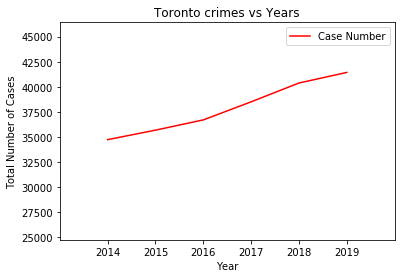

In [31]:
# Get the total number of crimes occurred on each year 
total_num=[]
total_num.append(len(crime2014["MCI"]))
total_num.append(len(crime2015["MCI"]))
total_num.append(len(crime2016["MCI"]))
total_num.append(len(crime2017["MCI"]))
total_num.append(len(crime2018["MCI"]))
total_num.append(len(crime2019["MCI"]))
for i in range(0,6):
    print(f"In {i+2014}, there are {total_num[i]} criminal crime occurred in Toronto.")
x_axis=["2014","2015","2016","2017","2018","2019"]
y_axis=total_num
plt.plot(x_axis,y_axis,color="red")
plt.xlabel("Year")
plt.ylabel("Total Number of Cases")
plt.xlim(-1,len(x_axis))
plt.ylim(min(y_axis)-10000,max(y_axis)+5000)
plt.legend(["Case Number"],loc="upper right")
plt.title(f"Toronto crimes vs Years")
plt.savefig(f"Image Output/Toronto crimes vs Years Line Chart.png")
plt.show()


# Question2: What time of the year the frequency of crime is highest? 
## a.	Correlation of crime with time of the day
## b.	Correlation of crime with different seasons/weather


In [34]:
# data file "Toronto_Crimes_Occurred_2014_2019.csv" to load and read
file = "Data Output/Toronto_Crimes_Occurred_2014_2019.csv"
crime_data = pd.read_csv(file)

# a column "Count" with 1 for accurate calculation
crime_data["Count"]= 1

#converting datatype of "occurrenceyear" to integer
crime_data=crime_data.astype({"occurrenceyear":int})

# crime data groupby year from 2014 to 2019
crime_data_Grp_year=crime_data.groupby('occurrenceyear').count()

### Seasonality of Crimes

#Oberservations

In [35]:
# step 1. get the average of number of crime occurred in each month over the last 6 years.   
crime_data_Grp_month=crime_data.groupby('occurrencemonth').count()/6

cats=['January','February','March','April', 'May','June','July','August', 'September','October','November', 'December']
crime_data_Grp_month.index = pd.CategoricalIndex(crime_data_Grp_month.index, categories=cats, ordered=True)
crime_data_Grp_month = crime_data_Grp_month.sort_index()


In [37]:
# Step 2. sort by calendar month
cats=['January','February','March','April', 'May','June','July','August', 'September','October','November', 'December']

crime_data_assult=crime_data.loc[(crime_data['MCI']=="Assault")]
crime_data_assult_month=crime_data_assult.groupby('occurrencemonth').count()/6
crime_data_assult_month.index = pd.CategoricalIndex(crime_data_assult_month.index, categories=cats,ordered=True)
crime_data_assult_month = crime_data_assult_month.sort_index()

crime_data_BnE=crime_data.loc[(crime_data['MCI']=="Break and Enter")]
crime_data_BnE_month=crime_data_BnE.groupby('occurrencemonth').count()/6
crime_data_BnE_month.index = pd.CategoricalIndex(crime_data_BnE_month.index, categories=cats,ordered=True)
crime_data_BnE_month = crime_data_BnE_month.sort_index()

crime_data_auto=crime_data.loc[(crime_data['MCI']=="Auto Theft")]
crime_data_auto_month=crime_data_auto.groupby('occurrencemonth').count()/6
crime_data_auto_month.index = pd.CategoricalIndex(crime_data_auto_month.index, categories=cats,ordered=True)
crime_data_auto_month = crime_data_auto_month.sort_index()

crime_data_robb=crime_data.loc[(crime_data['MCI']=="Robbery")]
crime_data_robb_month=crime_data_robb.groupby('occurrencemonth').count()/6
crime_data_robb_month.index = pd.CategoricalIndex(crime_data_robb_month.index, categories=cats,ordered=True)
crime_data_robb_month = crime_data_robb_month.sort_index()

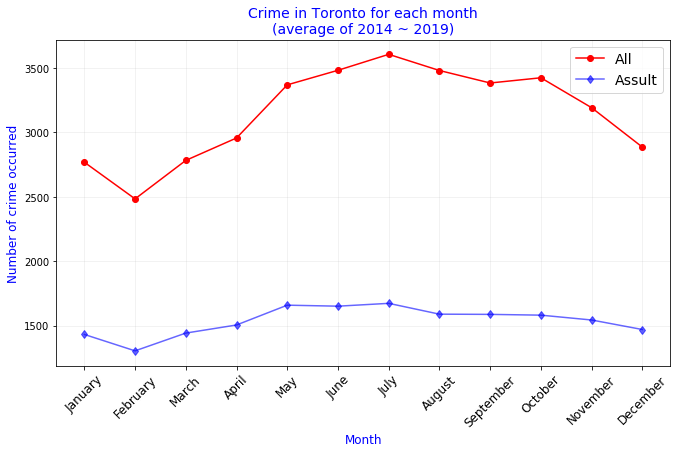

In [38]:
# Step. Seasonality of crime (monthly trend for crime type)
x_axis = cats

plt.figure(figsize=(11,6))

y_value= crime_data_Grp_month['Count']
all_crime, = plt.plot(x_axis, y_value, color ='red', marker = "o", label="All")

y_value= crime_data_assult_month['Count']
assult, =plt.plot(x_axis,y_value,color ='blue',alpha=0.6, marker="d",label="Assult")

plt.title("Crime in Toronto for each month\n(average of 2014 ~ 2019)",fontsize =14, color ='blue')
plt.xlabel('Month',fontsize =12,color ='blue')
plt.ylabel('Number of crime occurred',fontsize =12,color ='blue')
plt.grid(alpha=0.2)
plt.xticks(rotation=45,fontsize =12)
plt.legend(handles=[all_crime, assult], loc="best",fontsize =14 )

plt.savefig("Data Output/Crime_byMonth.png")
plt.show()

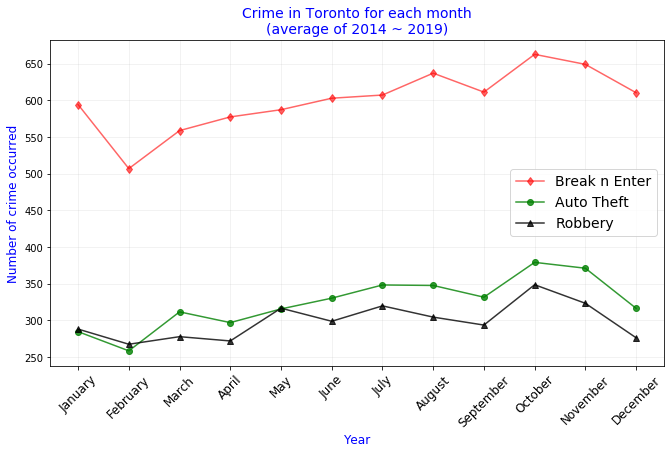

In [39]:
x_axis = cats
plt.figure(figsize=(11,6))

y_value= crime_data_BnE_month['Count']
BnE, =plt.plot(x_axis,y_value,color ='red',alpha=0.6, marker="d",label="Break n Enter")

y_value= crime_data_auto_month['Count']
auto, =plt.plot(x_axis,y_value,color ='green',alpha=0.8, marker="o",label="Auto Theft")

y_value= crime_data_robb_month['Count']
robb, =plt.plot(x_axis,y_value,color ='black',alpha=0.8, marker="^",label="Robbery")

plt.title("Crime in Toronto for each month\n(average of 2014 ~ 2019)",fontsize =14, color ='blue')
plt.xlabel('Year',fontsize =12,color ='blue')
plt.ylabel('Number of crime occurred',fontsize =12,color ='blue')
plt.grid(alpha=0.2)
plt.xticks(rotation=45,fontsize =12)
plt.legend(handles=[BnE,auto, robb], loc="best",fontsize =14 )

plt.savefig("Data Output/Others_byMonth.png")
plt.show()

###Correlation of crime with time of the day


In [41]:
crime_data_clean=crime_data.dropna()

In [42]:
#crime_data_Grp_hr
crime_data_clean=crime_data_clean.astype({"occurrencehour":int})
crime_data_Grp_hr=crime_data_clean.groupby('occurrencehour').count()/6
crime_data_Grp_hr=crime_data_Grp_hr.reset_index()

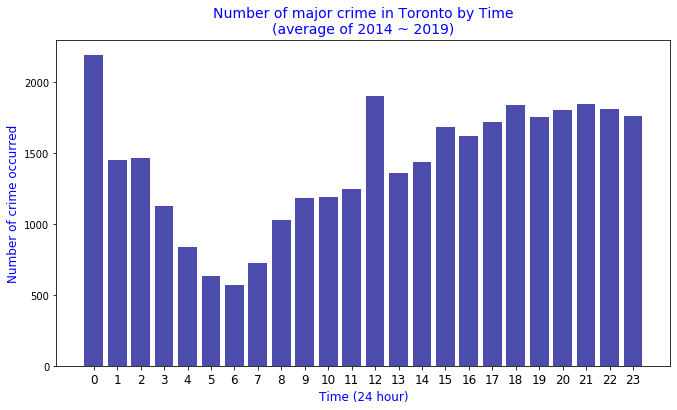

In [44]:
# Total crime by hour
x_axis = crime_data_Grp_hr["occurrencehour"]
y_value= crime_data_Grp_hr['Count']

plt.figure(figsize=(11,6))
plt.bar(x_axis,y_value, color ='darkblue',alpha=0.7)

plt.title("Number of major crime in Toronto by Time\n(average of 2014 ~ 2019)",fontsize =14, color ='blue')
plt.xlabel('Time (24 hour)',fontsize =12,color ='blue')
plt.ylabel('Number of crime occurred',fontsize =12,color ='blue')
plt.xticks(x_axis,rotation=0,fontsize =12)

plt.savefig("Data Output/major_crime_24hr.png")
plt.show()

In [45]:
# get the average (yearly) number of crime by hour (time) from 2014 to 2019
crime_data_assult_hr = crime_data_assult.groupby('occurrencehour').count()/6
crime_data_assult_hr = crime_data_assult_hr.reset_index()

crime_data_BnE_hr = crime_data_BnE.groupby('occurrencehour').count()/6
crime_data_BnE_hr = crime_data_BnE_hr.reset_index()

crime_data_auto_hr = crime_data_auto.groupby('occurrencehour').count()/6
crime_data_auto_hr = crime_data_auto_hr.reset_index()

crime_data_robb_hr = crime_data_robb.groupby('occurrencehour').count()/6
crime_data_robb_hr = crime_data_robb_hr.reset_index()

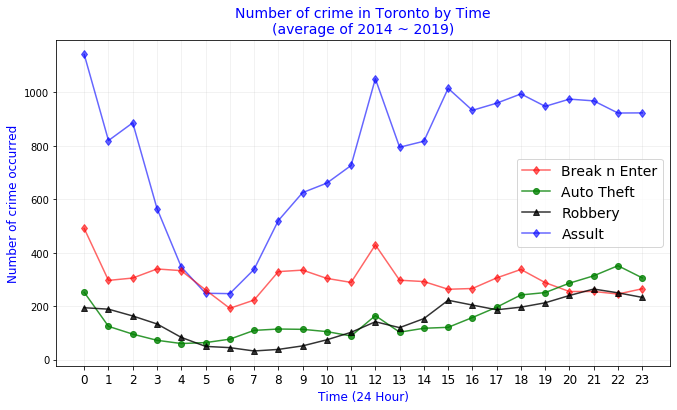

In [47]:
# crime type by hour for B&E, Assualt, Auto Theft and Robbery

plt.figure(figsize=(11,6))

x_axis = crime_data_assult_hr['occurrencehour']

y_value= crime_data_assult_hr['Count']
assult_hr, = plt.plot(x_axis,y_value,color ='blue',alpha=0.6, marker="d",label="Assult")

y_value= crime_data_BnE_hr['Count']
BnE, =plt.plot(x_axis,y_value,color ='red',alpha=0.6, marker="d",label="Break n Enter")

y_value= crime_data_auto_hr['Count']
auto, =plt.plot(x_axis,y_value,color ='green',alpha=0.8, marker="o",label="Auto Theft")

y_value= crime_data_robb_hr['Count']
robb, =plt.plot(x_axis,y_value,color ='black',alpha=0.8, marker="^",label="Robbery")

plt.title("Number of crime in Toronto by Time\n(average of 2014 ~ 2019)",fontsize =14, color ='blue')
plt.xlabel('Time (24 Hour)',fontsize =12,color ='blue')
plt.ylabel('Number of crime occurred',fontsize =12,color ='blue')
plt.grid(alpha=0.2)
plt.xticks(x_axis,rotation=0,fontsize =12)
plt.legend(handles=[BnE,auto, robb, assult], loc="best",fontsize =14 )

plt.savefig("Data Output/Others_crime_24hr.png")
plt.show()

### Q3. Crimes by Neighbourhood
    a. Which neighborhoods experience the highest and lowest crime cases in Toronto?
    b. How close were police stations to where the crimes occurred?

In [48]:
# import cleaned master crime csv file
master_file = "Data Output/Toronto_Crimes_Occurred_2014_2019.csv"

# create a dataframe from the master data
master_df = pd.read_csv(master_file, index_col=0)


In [49]:
# ************************************************************************************************
# use master crime dataset to generate heat map of total crimes across Toronto by neighbourhood
# ************************************************************************************************

# configure gmaps figure
gmaps.configure(api_key=g_key)

# Toronto's coordinates for centering the map
toronto_coords = (43.70, -79.33)

# create base map
fig = gmaps.figure(center=toronto_coords, zoom_level=11)
locations = master_df[["Lat", "Long"]]

heatmap_layer = gmaps.heatmap_layer(locations)
fig.add_layer(heatmap_layer)

# adjust layer settings for increased visibility
heatmap_layer.max_intensity = 50
heatmap_layer.point_radius = 4
fig

Figure(layout=FigureLayout(height='420px'))

In [50]:
# ************************************************************************************************
# create a neighbourhoods dataframe with total crimes in descending order 
# ************************************************************************************************

# sort the master dataframe by neighbourhood ID and create a dictionary with relevant neighbourhood details
master_df_sorted = master_df.sort_values("Hood_ID")
neighbourhood_crimes_dict = {"Neighbourhood ID": master_df_sorted["Hood_ID"].unique(),
                             "Hood Lat": master_df_sorted.groupby("Hood_ID")["Lat"].mean(),
                             "Hood Lng": master_df_sorted.groupby("Hood_ID")["Long"].mean(),
                             "No. of Crimes": master_df_sorted.groupby("Hood_ID")["event_unique_id"].count()
}

# create new dataframe from the dictionary, add neighbourhood column and sort in total crimes descending order 
neighbourhood_crimes_df = pd.DataFrame(neighbourhood_crimes_dict).set_index("Neighbourhood ID")
neighbourhood_crimes_df["Neighbourhood"] = master_df_sorted["Neighbourhood"].unique()
neighbourhood_crimes_df.sort_values("No. of Crimes", ascending=False, inplace=True)

neighbourhood_crimes_df

,Hood Lat,Hood Lng,No. of Crimes,Neighbourhood
Neighbourhood ID,,,,
77,43.644959,-79.387431,9984,Waterfront Communities-The Island (77)
76,43.657212,-79.383738,8765,Bay Street Corridor (76)
75,43.659622,-79.379598,7641,Church-Yonge Corridor (75)
1,43.721569,-79.597207,5759,West Humber-Clairville (1)
73,43.656880,-79.369331,5502,Moss Park (73)
...,...,...,...,...
12,43.634161,-79.573765,467,Markland Wood (12)
140,43.748982,-79.198807,424,Guildwood (140)
29,43.714195,-79.480897,408,Maple Leaf (29)


In [51]:
# ************************************************************************************************
# find the neighborhoods that experience the highest and lowest crime cases in Toronto
# ************************************************************************************************

# create dataframes with top 10 crime (most crime) and bottom 10 (least crime) neighbourhoods 
most_crimes_neighbourhoods = neighbourhood_crimes_df.head(10)
least_crimes_neighbourhoods = neighbourhood_crimes_df.tail(10).sort_values("No. of Crimes")


In [52]:
# display 10 neighbourhoods with most crimes
most_crimes_neighbourhoods

,Hood Lat,Hood Lng,No. of Crimes,Neighbourhood
Neighbourhood ID,,,,
77,43.644959,-79.387431,9984,Waterfront Communities-The Island (77)
76,43.657212,-79.383738,8765,Bay Street Corridor (76)
75,43.659622,-79.379598,7641,Church-Yonge Corridor (75)
1,43.721569,-79.597207,5759,West Humber-Clairville (1)
73,43.656880,-79.369331,5502,Moss Park (73)
78,43.653612,-79.397825,4551,Kensington-Chinatown (78)
27,43.763923,-79.489869,4131,York University Heights (27)
26,43.727890,-79.498073,4039,Downsview-Roding-CFB (26)
137,43.766636,-79.228039,3854,Woburn (137)


In [53]:
# display 10 neighbourhoods with least crimes
least_crimes_neighbourhoods

,Hood Lat,Hood Lng,No. of Crimes,Neighbourhood
Neighbourhood ID,,,,
114,43.659076,-79.495543,397,Lambton Baby Point (114)
60,43.694210,-79.312666,398,Woodbine-Lumsden (60)
29,43.714195,-79.480897,408,Maple Leaf (29)
140,43.748982,-79.198807,424,Guildwood (140)
12,43.634161,-79.573765,467,Markland Wood (12)
58,43.694486,-79.337386,493,Old East York (58)
97,43.688566,-79.396944,505,Yonge-St.Clair (97)
8,43.692357,-79.522358,525,Humber Heights-Westmount (8)
133,43.782788,-79.149991,530,Centennial Scarborough (133)


In [54]:
# **************************************************************************************************
# add symbols for the most & least dangerous neighbourhood to the heatmap
# **************************************************************************************************

# info box template for pop up message over symbols

info_box_list_most = """
<dl>
<dt>Neighbourhood</dt><dd>{Neighbourhood}</dd>
</dl>
"""

info_box_list_least = """
<dl>
<dt>Neighbourhood</dt><dd>{Neighbourhood}</dd>
</dl>
"""

# Store the DataFrame rows for neighbourhoods
dangerous_neighbourhood_info = [info_box_list_most.format(**row) for index, row in most_crimes_neighbourhoods.iterrows()]
most_crime_locations = most_crimes_neighbourhoods[["Hood Lat", "Hood Lng"]]
dangerous_names = most_crimes_neighbourhoods["Neighbourhood"].to_list()

safe_neighbourhood_info = [info_box_list_least.format(**row) for index, row in least_crimes_neighbourhoods.iterrows()]
least_crime_locations = least_crimes_neighbourhoods[["Hood Lat", "Hood Lng"]]
safe_names = least_crimes_neighbourhoods["Neighbourhood"].to_list()

In [55]:
# create symbol layers for top 10 most dangerous neighourhoods and top 10 most safe neighbourhoods 
most_crime_symbols = gmaps.symbol_layer(most_crime_locations, scale=5, fill_color="red", stroke_color="black", 
                                        hover_text=dangerous_names, info_box_content=info_box_list_most)


least_crime_symbols = gmaps.symbol_layer(least_crime_locations, scale=5, fill_color='blue', stroke_color='green', 
                                         hover_text=safe_names, info_box_content=info_box_list_least)

# add symbol layers to the heatmap
fig.add_layer(most_crime_symbols)
fig.add_layer(least_crime_symbols)
fig

Figure(layout=FigureLayout(height='420px'))

In [56]:
# **************************************************************************************************
# find the geocoordinates of Toronto police stations in the top 10 neighbourhoods with most crimes
# to add as markers on heatmap
# **************************************************************************************************

# create columns with initially null values for police station and its location
most_crimes_neighbourhoods["Police Station"] = np.nan
most_crimes_neighbourhoods["Police Station Lat"] = np.nan
most_crimes_neighbourhoods["Police Station Lng"] = np.nan
     
# set up parameters for querying Google Places API 
target_search = "police"
target_radius = 5000
target_type = "police"

# set up a parameters dictionary 
params = {
    "keyword": target_search,
    "radius": target_radius,
    "type": target_type,
    "key": g_key
}

# --- define base url ---
base_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"


In [57]:
# use a for loop to go through each neighbourhood in the dataframe and make an API call 

for index, row in most_crimes_neighbourhoods.iterrows():
    
    # get the neighbourhood coordinates and store in params dictionary 
    lat = row["Hood Lat"]
    lng = row["Hood Lng"]
    params["location"] = f"{lat},{lng}"
    
    # call the API and get police station details for each neighbourhood 
    police_data = requests.get(base_url, params).json()
    
    # use exception handling to store the police station and location for each neighbourhood 
    
    try:
        station_name = police_data["results"][0]["name"]
        location_lat = police_data["results"][0]["geometry"]["location"]["lat"]
        location_lng = police_data["results"][0]["geometry"]["location"]["lng"]
        
        most_crimes_neighbourhoods.loc[index, "Police Station"] = station_name
        most_crimes_neighbourhoods.loc[index, "Police Station Lat"] = location_lat    
        most_crimes_neighbourhoods.loc[index, "Police Station Lng"] = location_lng  
        
        print(f"Police Station found for '{row['Neighbourhood']}'!")
        print(f"The nearest station is {station_name}")
        print("------------------------------------------------------------------------------------")
              
    except:
        print(f"Could not find information for neighbourhood '{row['Neighbourhood']}'... skipping.")    
        print("------------------------------------------------------------------------------------")
        

Police Station found for 'Waterfront Communities-The Island (77)'!
The nearest station is Toronto Police Service 52 Division
------------------------------------------------------------------------------------
Police Station found for 'Bay Street Corridor (76)'!
The nearest station is Toronto Police Service 52 Division
------------------------------------------------------------------------------------
Police Station found for 'Church-Yonge Corridor (75)'!
The nearest station is Toronto Police Service 52 Division
------------------------------------------------------------------------------------
Police Station found for 'West Humber-Clairville (1)'!
The nearest station is Toronto Police Service 23 Division
------------------------------------------------------------------------------------
Police Station found for 'Moss Park (73)'!
The nearest station is Toronto Police Service 52 Division
------------------------------------------------------------------------------------
Police Stati

In [58]:
# NOTE: Do not change any of the code in this cell

# Using the template add the police markers to the heatmap

info_box_template = """
<dl>
<dt>Name</dt><dd>{Police Station}</dd>
</dl>
"""
# Store the DataFrame Row
# NOTE: be sure to update with your DataFrame name
police_info = [info_box_template.format(**row) for index, row in most_crimes_neighbourhoods.iterrows()]
locations = most_crimes_neighbourhoods[["Police Station Lat", "Police Station Lng"]]

In [59]:
# add police station marker layer on top of heat map 
markers = gmaps.marker_layer(locations, info_box_content = police_info)
fig.add_layer(markers)

# Display figure
fig

Figure(layout=FigureLayout(height='420px'))

In [60]:
most_crimes_neighbourhoods

,Hood Lat,Hood Lng,No. of Crimes,Neighbourhood,Police Station,Police Station Lat,Police Station Lng
Neighbourhood ID,,,,,,,
77,43.644959,-79.387431,9984,Waterfront Communities-The Island (77),Toronto Police Service 52 Division,43.654179,-79.389450
76,43.657212,-79.383738,8765,Bay Street Corridor (76),Toronto Police Service 52 Division,43.654179,-79.389450
75,43.659622,-79.379598,7641,Church-Yonge Corridor (75),Toronto Police Service 52 Division,43.654179,-79.389450
1,43.721569,-79.597207,5759,West Humber-Clairville (1),Toronto Police Service 23 Division,43.743720,-79.584475
73,43.656880,-79.369331,5502,Moss Park (73),Toronto Police Service 52 Division,43.654179,-79.389450
78,43.653612,-79.397825,4551,Kensington-Chinatown (78),Toronto Police Service 52 Division,43.654179,-79.389450
27,43.763923,-79.489869,4131,York University Heights (27),Toronto Police Service 31 Division,43.756792,-79.527411
26,43.727890,-79.498073,4039,Downsview-Roding-CFB (26),Toronto Police 12 Division,43.694432,-79.486998
137,43.766636,-79.228039,3854,Woburn (137),Toronto Police Service,43.749603,-79.288540


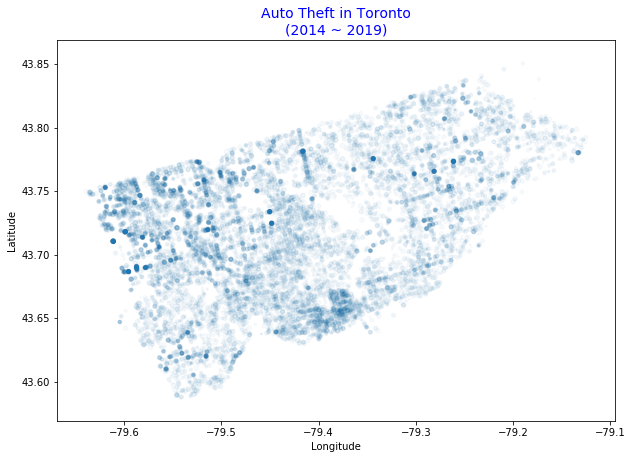

In [61]:
# Auto Theft in Toronto over 2014-2019

plt.figure(figsize=(10,7))
autoTheft = plt.scatter(crime_data_auto['Long'], crime_data_auto['Lat'], s=x_axis,alpha=0.03)
#clb =plt.colorbar()

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Auto Theft in Toronto\n(2014 ~ 2019)",fontsize =14, color ='blue')

plt.savefig("Data Output/autoTheft_map.png")
plt.show()

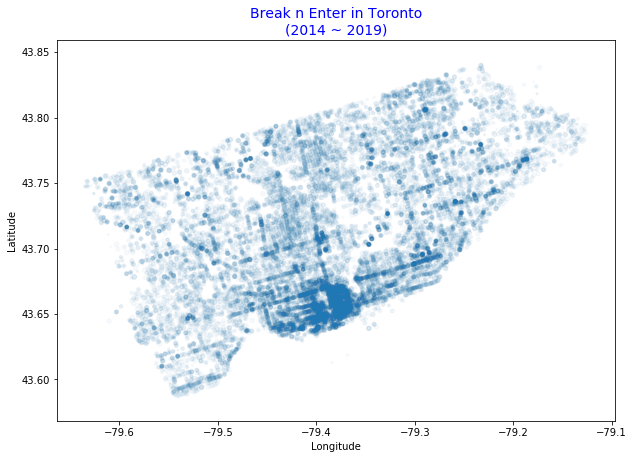

In [62]:
# Break'n Enter on Map
plt.figure(figsize=(10,7))
autoTheft = plt.scatter(crime_data_BnE['Long'], crime_data_BnE['Lat'], s=x_axis,alpha=0.03)
#clb =plt.colorbar()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Break n Enter in Toronto\n(2014 ~ 2019)",fontsize =14, color ='blue')

plt.savefig("Data Output/BnE_map.png")
plt.show()

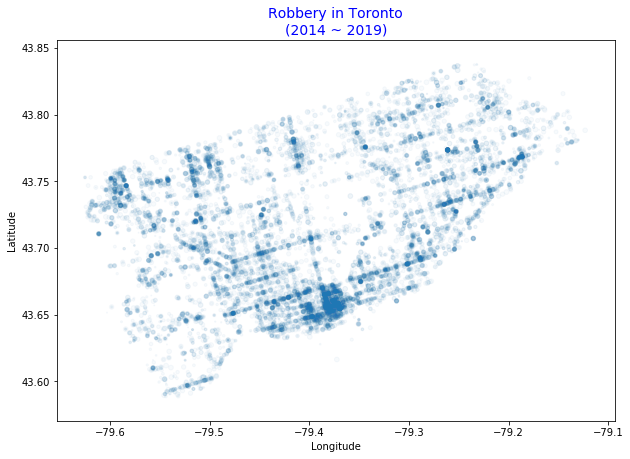

In [63]:
# Robbery on Map
plt.figure(figsize=(10,7))
robbery = plt.scatter(crime_data_robb['Long'], crime_data_robb['Lat'], s=x_axis,alpha=0.035)
#clb =plt.colorbar()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Robbery in Toronto\n(2014 ~ 2019)",fontsize =14, color ='blue')

plt.savefig("Data Output/robbery_map.png")
plt.show()

# Question 4.	In what kinds of properties do the following crimes occur? (house, commercial, apartment, etc)
a.	Break-and-enter
b.	Homicide
c.	Robbery


In [64]:
#read output file
data="Data Output/Toronto_Crimes_Occurred_2014_2019.csv"
data_df= pd.read_csv(data, encoding="ISO-8859-1")
#drop na values
newtable=data_df.dropna()
newtable["reportedyear"]=newtable["reportedyear"].astype(int)

<function matplotlib.pyplot.show(*args, **kw)>

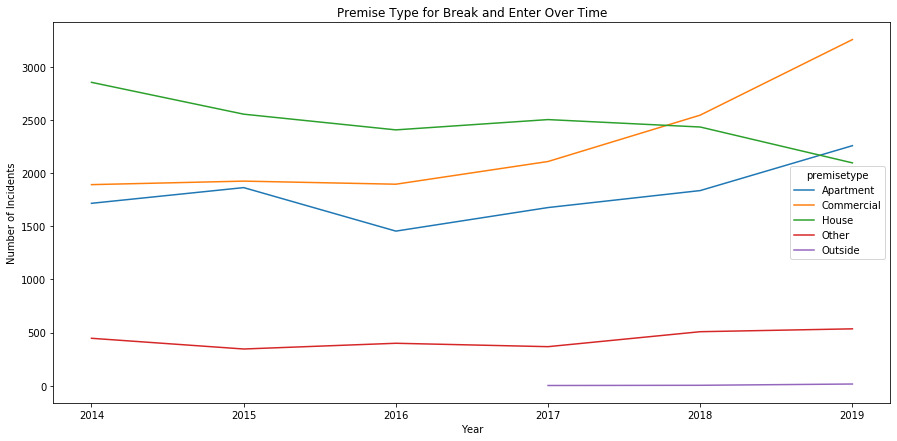

In [65]:
# filter out B&E Data
B_table=newtable[newtable['offence'].str.contains("B&E")]
x=B_table["premisetype"].unique()
# plot data over year 
fig, ax = plt.subplots(figsize=(15,7))
yeartrend=B_table.groupby("reportedyear")["premisetype"].value_counts().unstack().plot(ax=ax)
plt.title("Premise Type for Break and Enter Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Incidents")
plt.show


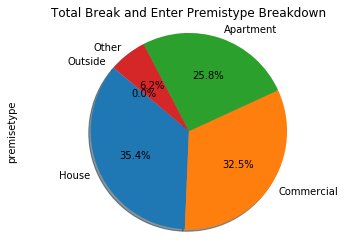

In [66]:
#Total Break Down (over 6 years)
x=B_table["premisetype"].value_counts()
pie_chart=x.plot(kind='pie',autopct='%1.1f%%',shadow=True, startangle=140, title="Total Break and Enter Premistype Breakdown",legend=False)
pie_chart.axis("equal")
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

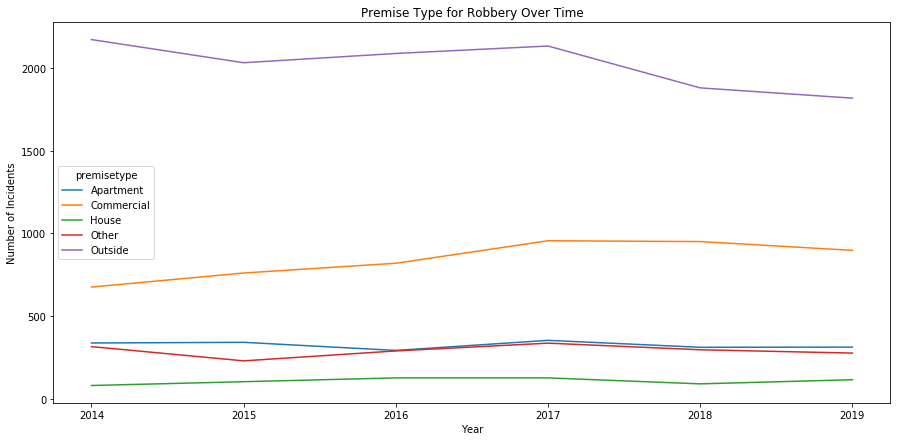

In [67]:
# filter out Robberry Data
R_table=newtable[newtable['offence'].str.contains("Robbery")]
x=R_table["premisetype"].unique()
#plot data over year boxplot=Final_Drug_Table.boxplot(column="Tumor Volume (mm3)",by="Drug Regimen",grid=False,flierprops=blue_square)
fig, ax = plt.subplots(figsize=(15,7))
yeartrend1=R_table.groupby("reportedyear")["premisetype"].value_counts().unstack().plot(ax=ax)
plt.title("Premise Type for Robbery Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Incidents")
plt.show

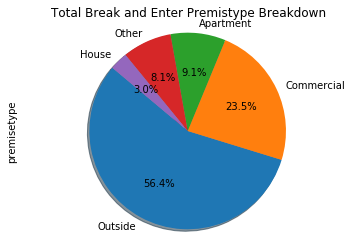

In [68]:
#Total Break Down (over 6 years)
x=R_table["premisetype"].value_counts()
pie_chart=x.plot(kind='pie',autopct='%1.1f%%',shadow=True, startangle=140, title="Total Break and Enter Premistype Breakdown",legend=False)
pie_chart.axis("equal")
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

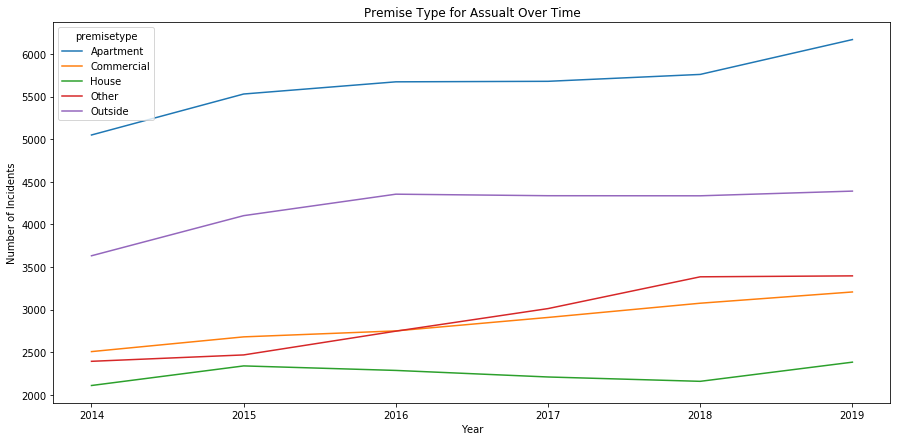

In [69]:
# filter out Assualt Data
A_table=newtable[newtable['offence'].str.contains("Assault")]
x=B_table["premisetype"].unique()
# plot data over year 
fig, ax = plt.subplots(figsize=(15,7))
yeartrend=A_table.groupby("reportedyear")["premisetype"].value_counts().unstack().plot(ax=ax)
plt.title("Premise Type for Assualt Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Incidents")
plt.show

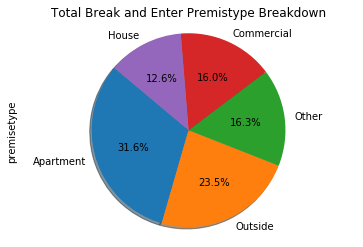

In [70]:
#Total Break Down (over 6 years)
x=A_table["premisetype"].value_counts()
pie_chart=x.plot(kind='pie',autopct='%1.1f%%',shadow=True, startangle=140, title="Total Break and Enter Premistype Breakdown",legend=False)
pie_chart.axis("equal")
plt.show()
